Logistic Regression    
Features: steps & ingredients

Test score: 0.802125   
Kaggle score: 0.81200

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import GenericUnivariateSelect, chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

from load_data import *
from utils import *

In [4]:
def preprocess(df):
    arr_steps = df['steps'].copy().to_numpy()
    arr_ingr = df['ingredients'].copy().to_numpy()
    for i in range(len(arr_steps)):
        arr_steps[i] = str(arr_steps[i]).replace("[", "").replace("]", "").replace(",", "").replace("'", "")
        arr_ingr[i] = str(arr_ingr[i]).replace("[", "").replace("]", "").replace(",", "").replace("'", "")
    
    X = arr_steps + arr_ingr
    return X

Run the model without feature selection

In [5]:
X = preprocess(df_train)
y = df_train['duration_label']

vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
X = vectorizer.fit_transform(X)

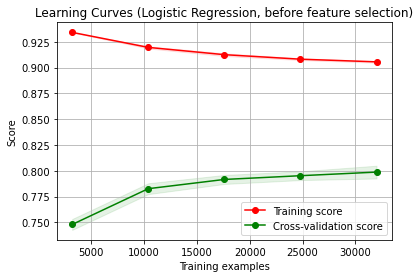

In [17]:
lg = LogisticRegression(max_iter=1000)
title = "Learning Curves (Logistic Regression, before feature selection)"
plot_learning_curves(lg, title, X, y, n_jobs=-1)

Run the model with Feature selection


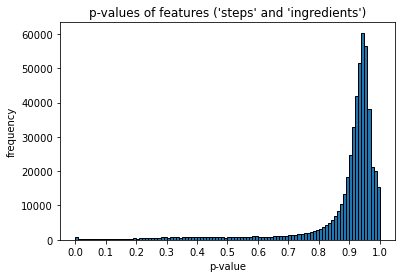

In [9]:
chi_square, p_values = chi2(X, y)
plt.hist(p_values, edgecolor = 'black', bins=100)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.title("p-values of features ('steps' and 'ingredients')")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

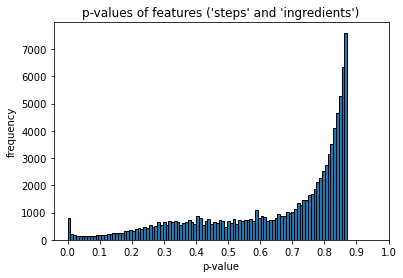

In [6]:
fselect = GenericUnivariateSelect(chi2, mode='percentile', param=20)
X_new = fselect.fit_transform(X, y)

chi_square, p_values = chi2(X_new, y)
plt.hist(p_values, edgecolor = 'black', bins=100)
plt.xlabel('p-value')
plt.ylabel('frequency')
plt.title("p-values of features ('steps' and 'ingredients')")
plt.xticks(np.arange(0,1.1,0.1))
plt.show()

In [15]:
lg = LogisticRegression(max_iter=1000, C=10, penalty='l2', solver='liblinear')
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
lg.fit(X_train, y_train)
lg.score(X_test, y_test)

0.817

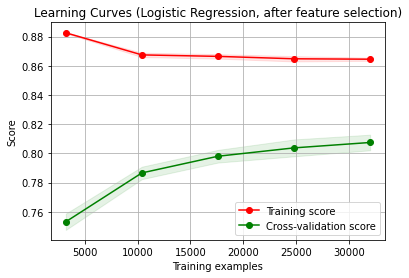

In [8]:
lg = LogisticRegression(max_iter=1000)
title = "Learning Curves (Logistic Regression, after feature selection)"
plot_learning_curves(lg, title, X_new, y, n_jobs=-1)

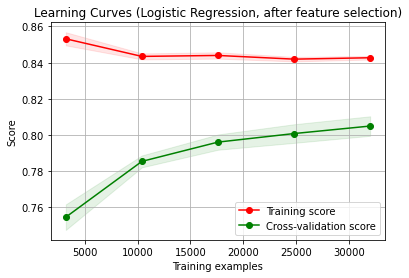

In [16]:
lg = LogisticRegression(max_iter=1000)
title = "Learning Curves (Logistic Regression, after feature selection)"
plot_learning_curves(lg, title, X_new, y, n_jobs=-1)

In [17]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', "sag", "saga"]
penalties = ['l2', 'l1', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalties,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_new, y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    if mean != 0:
        print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.815875 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.809400 (0.004746) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.801525 (0.005195) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.810750 (0.004462) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.809350 (0.004927) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.809225 (0.005066) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.783200 (0.004963) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.801000 (0.005092) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.815175 (0.005279) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.811000 (0.005254) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.815875 (0.004896) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.815175 (0.005279) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.815100 (0.005423) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.792475 (0.004962) with: {'C': 10, 'penalty'

Run the model after hyperparameter tuning

In [8]:
lg = LogisticRegression(C= 10, penalty='l2', solver='liblinear')
lg.fit(X_train_new, y_train)
lg.score(X_test_new, y_test)

0.803375

Predict Kaggle test set

In [9]:
X_train = preprocess(df_train)
X_test = preprocess(df_test)
X = np.concatenate((X_train, X_test), axis=0)
y_train = df_train['duration_label']

vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
vectorizer.fit(X)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

fselect = GenericUnivariateSelect(chi2, mode='percentile', param=5)
fselect.fit(X_train, y_train)
X_train_new = fselect.transform(X_train)
X_test_new = fselect.transform(X_test)

lg = LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2', C=10)
lg.fit(X_train_new, y_train)
predicts = lg.predict(X_test_new)

ids = np.array(range(len(predicts))) + 1
output = pd.DataFrame({'id': ids, 'duration_label': predicts})
output.to_csv('output.csv', index=False)

Hyperparameter tuning

In [4]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', "sag", "saga"]
penalties = ['l2', 'l1', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver=solvers,penalty=penalties,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    if mean != 0:
        print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.791312 using {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
0.762906 (0.005463) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.761156 (0.001928) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.770250 (0.003837) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.763531 (0.005168) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.763969 (0.005227) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.748062 (0.005696) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.760094 (0.005611) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.781625 (0.004623) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.781406 (0.004916) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.786937 (0.004773) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.781719 (0.004573) with: {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
0.781688 (0.004415) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.776438 (0.003232) with: {'C': 10, 'penalty

Predict Kaggle test set and save output.csv

In [ ]:
X_train = preprocess(df_train)
X_test = preprocess(df_test)
y_train = df_train['duration_label']
vectorizer = vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

fselect = GenericUnivariateSelect(chi2, mode='percentile', param=15)
fselect.fit(X_train, y_train)
X_train_new = fselect.transform(X_train)
X_test_new = fselect.transform(X_test)

lg = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear', penalty='l1', C=1.0)
lg.fit(X_train_new, y_train)
predicts = lg.predict(X_test_new)

ids = np.array(range(len(predicts))) + 1
output = pd.DataFrame({'id': ids, 'duration_label': predicts})
output.to_csv('output.csv', index=False)